# Graph Attention Networks
## Máster Oficial: Big Data Science

https://www.unav.edu/web/instituto-de-ciencia-de-los-datos-e-inteligencia-artificial<br>

Autor: Darian Horacio Grass Boada

# Redes de Atención de Grafo (GATs)

Las Redes de Atención de Grafo (GATs) son uno de los tipos más populares de Redes Neuronales de Grafo.

En lugar de calcular pesos estáticos basados en grados de nodos como las Redes Convolutivas de Grafo (GCNs), asignan pesos dinámicos a las características de los nodos a través de un proceso llamado auto-atención. La idea principal detrás de las GATs es que algunos vecinos son más importantes que otros, independientemente de sus grados de nodo.

# Implementación de GAT en PyTorch Geometric

En este artículo, veremos cómo calcular estos puntajes de atención e implementar una GAT eficiente en PyTorch Geometric (PyG). Puedes ejecutar el código de este tutorial con el siguiente cuaderno de Google Colab.

In [ ]:
# We assume that PyTorch is already installed
import torch
torchversion = torch.__version__

# Install PyTorch Scatter, PyTorch Sparse, and PyTorch Geometric
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torchversion}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torchversion}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Numpy for matrices
import numpy as np
np.random.seed(0)

# Visualization
import networkx as nx
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 13.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Dataset

# Clasificación de Nodos con GAT

Vamos a realizar una tarea de clasificación de nodos con una GAT. Podemos usar tres conjuntos de datos de grafo clásicos (licencia MIT) para este trabajo. Representan redes de trabajos de investigación, donde cada conexión es una cita.

- Cora: consta de 2,708 trabajos de aprendizaje automático que pertenecen a una de siete categorías. ➡️ Las características de los nodos representan la presencia (1) o ausencia (0) de 1,433 palabras en un trabajo (bolsa de palabras binaria).
- CiteSeer: es un conjunto de datos más grande pero similar de 3,327 trabajos científicos para clasificar en una de seis categorías. ➡️ Las características de los nodos representan la presencia (1) o ausencia (0) de 3,703 palabras en un trabajo.
- PubMed: es un conjunto de datos aún más grande con 19,717 publicaciones científicas sobre diabetes de la base de datos de PubMed, clasificadas en tres categorías. ➡️ Las características de los nodos son vectores de palabras ponderados por TF-IDF de un diccionario de 500 palabras únicas.

Estos conjuntos de datos han sido ampliamente utilizados por la comunidad científica. Como desafío, podemos comparar nuestros puntajes de precisión con los obtenidos en la literatura (con desviación estándar) utilizando Perceptrones Multicapa (MLPs), GCNs y GATs:

| Conjunto de datos | 📝Cora | 📝CiteSeer | 📝PubMed |
| --- | --- | --- | --- |
| MLP | 55.1% | 46.5% | 71.4% |
| GCN | 81.4 ± 0.5% | 70.9% ± 0.5% | 79.0% ± 0.3% |
| GAT | 83.0% ± 0.7% | 72.5% ± 0.7% | 79.0% ± 0.3% |

PubMed es bastante grande, por lo que llevaría más tiempo procesar y entrenar una GNN en él. Por otro lado, Cora es el más estudiado en la literatura, así que vamos a centrarnos en CiteSeer como un término medio.

Podemos importar directamente cualquiera de estos conjuntos de datos en PyTorch Geometric con la clase Planetoid:

In [ ]:
from torch_geometric.datasets import Planetoid

# Import dataset from PyTorch Geometric
dataset = Planetoid(root=".", name="CiteSeer")

data = dataset[0]

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Processing...
Done!


Dataset: CiteSeer()
-------------------
Number of graphs: 1
Number of nodes: 3327
Number of features: 3703
Number of classes: 6

Graph:
------
Edges are directed: False
Graph has isolated nodes: True
Graph has loops: False


In [ ]:
from torch_geometric.utils import remove_isolated_nodes

isolated = (remove_isolated_nodes(data['edge_index'])[2] == False).sum(dim=0).item()
print(f'Number of isolated nodes = {isolated}')

Number of isolated nodes = 48


# Plot dataset

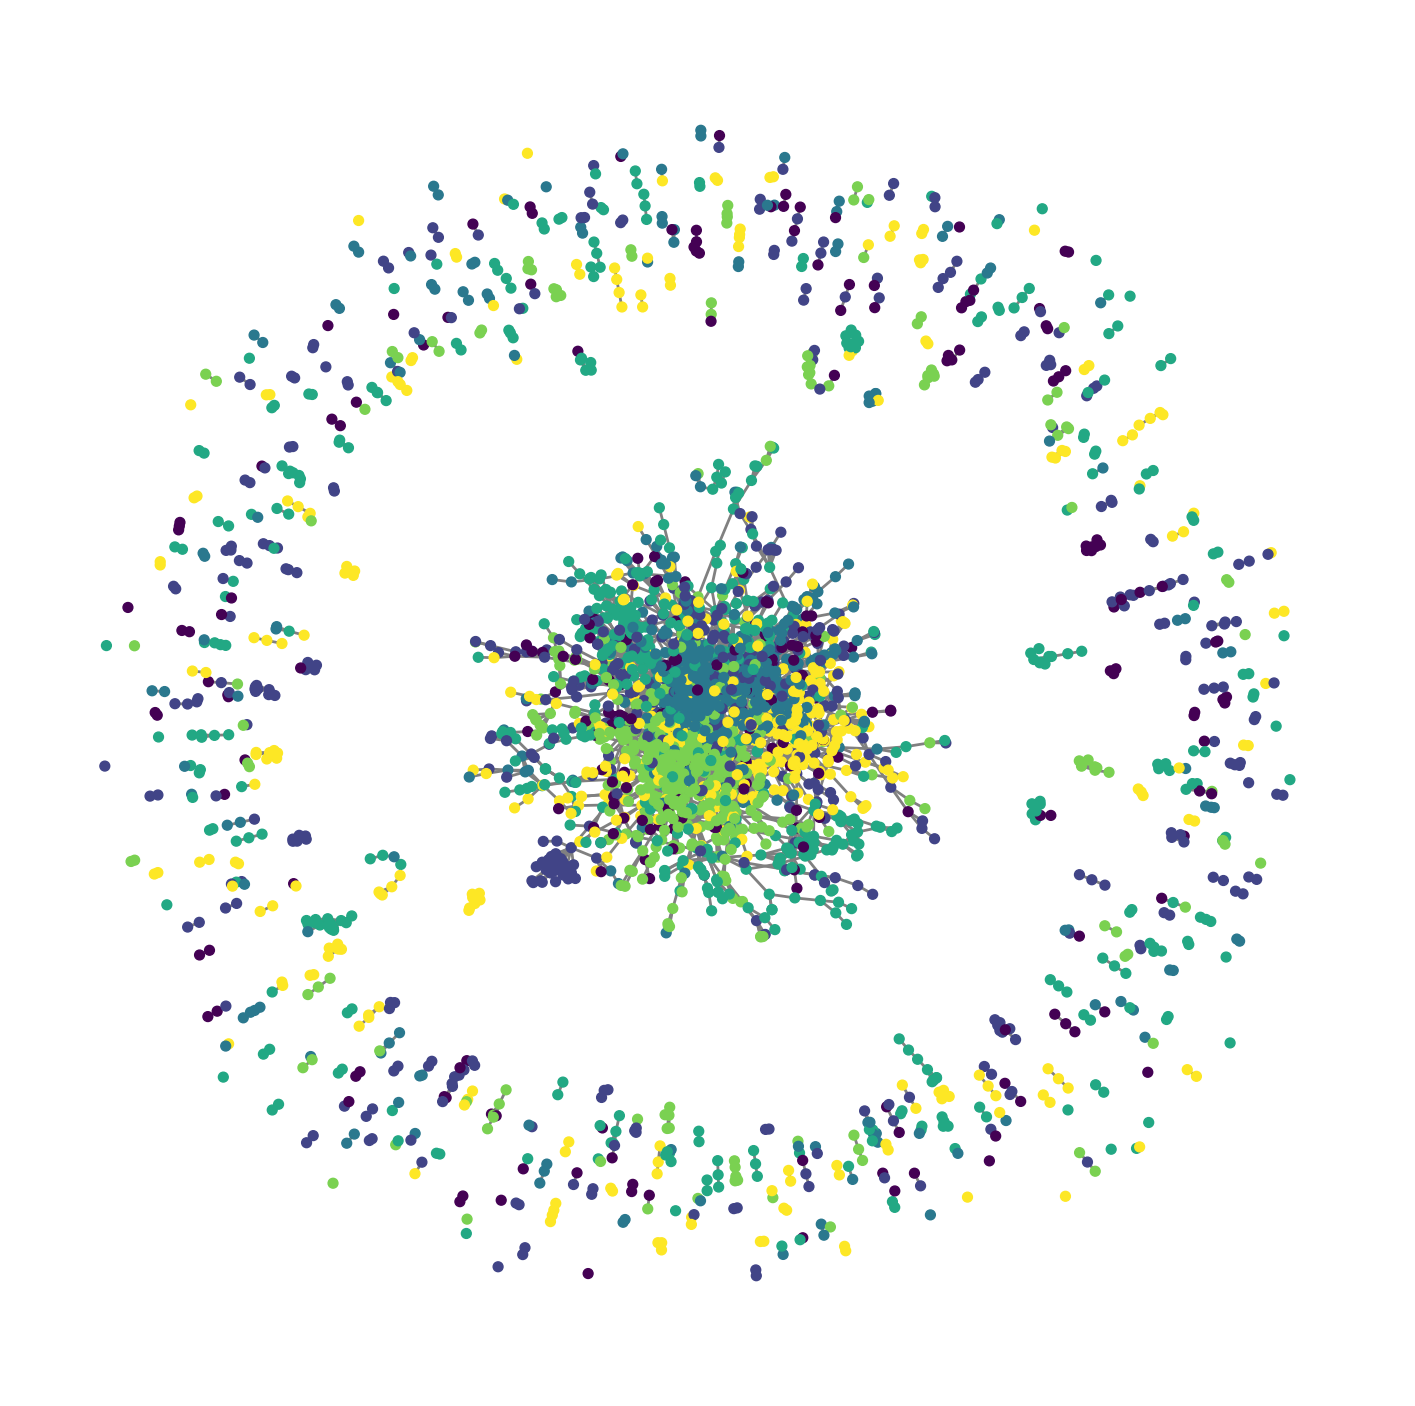

In [ ]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(18,18))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=False,
                node_size=50,
                node_color=data.y,
                width=2,
                edge_color="grey"
                )
plt.show()

# Plot node degrees

# El Conjunto de Datos CiteSeer

El conjunto de datos CiteSeer muestra correctamente las características que describimos anteriormente. Sin embargo, algunos nodos están aislados (¡48 para ser precisos!). Clasificar correctamente estos nodos aislados será un desafío ya que no podemos confiar en ninguna agregación. Así es como un MLP procesa los nodos: no puede considerar la matriz de adyacencia, lo que disminuye su precisión.

Vamos a trazar el número de conexiones de cada nodo con grado:

<BarContainer object of 32 artists>

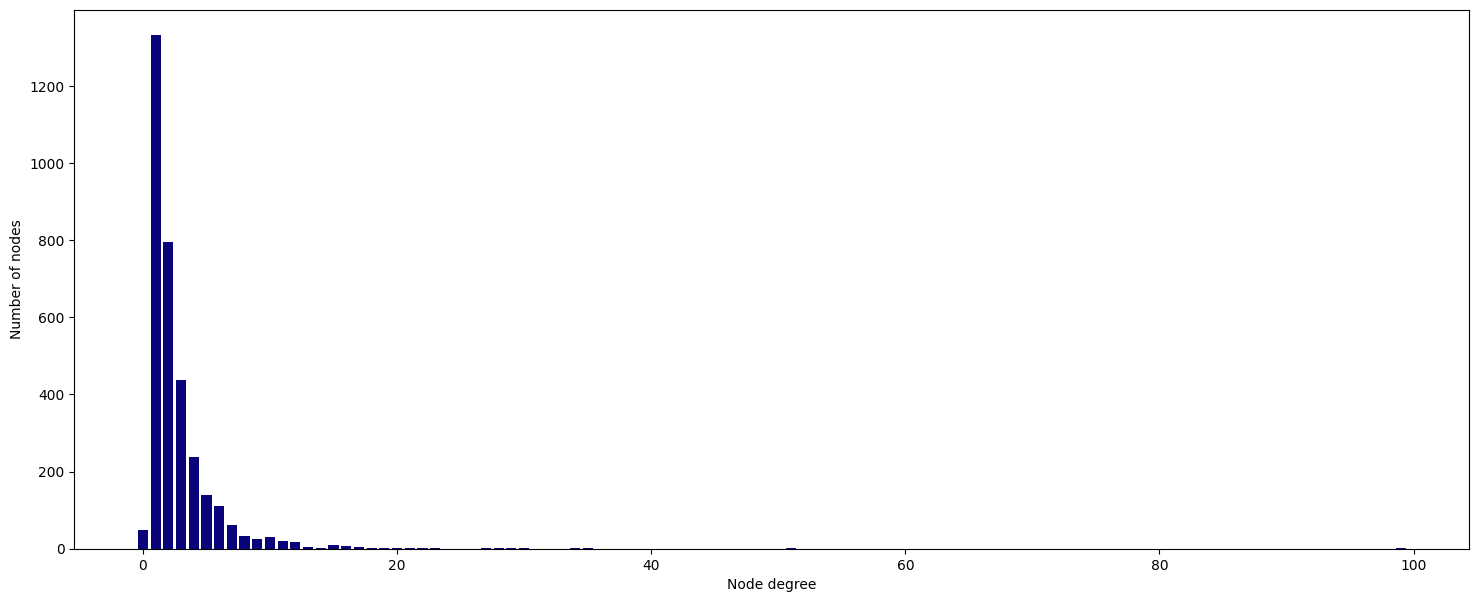

In [ ]:
from torch_geometric.utils import degree
from collections import Counter

# Get list of degrees for each node
degrees = degree(data.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots(figsize=(18, 7))
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(),
        numbers.values(),
        color='#0A047A')

# Implementación de una Red de Atención de Grafo

Ahora vamos a implementar una GAT en PyTorch Geometric. Esta biblioteca tiene dos capas diferentes de atención de grafo: GATConv y GATv2Conv.

Ten en cuenta que usamos capas de atención de grafo en dos configuraciones:

- La primera capa concatena 8 salidas (atención multi-cabeza);
- La segunda capa solo tiene 1 cabeza, que produce nuestras incrustaciones finales.

También vamos a entrenar y probar una GCN con dos capas GCN (y dropout) para comparar los puntajes de precisión.

# Implement GAT vs. GCN

In [ ]:
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATv2Conv


class GCN(torch.nn.Module):
  """Graph Convolutional Network"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.gcn1 = GCNConv(dim_in, dim_h)
    self.gcn2 = GCNConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.5, training=self.training)
    h = self.gcn1(h, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.gcn2(h, edge_index)
    return h, F.log_softmax(h, dim=1)


class GAT(torch.nn.Module):
  """Graph Attention Network"""
  def __init__(self, dim_in, dim_h, dim_out, heads=8):
    super().__init__()
    self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
    self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.005,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.6, training=self.training)
    h = self.gat1(x, edge_index)
    h = F.elu(h)
    h = F.dropout(h, p=0.6, training=self.training)
    h = self.gat2(h, edge_index)
    return h, F.log_softmax(h, dim=1)

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

def train(model, data):
    """Train a GNN model and return the trained model."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer
    epochs = 200

    model.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        _, out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

    return model

def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

# Train GCN

In [ ]:
%%time

# Create GCN model
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)

# Train
train(gcn, data)

# Test
acc = test(gcn, data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(3703, 16)
  (gcn2): GCNConv(16, 6)
)
Epoch   0 | Train Loss: 1.792 | Train Acc:  19.17% | Val Loss: 1.81 | Val Acc: 10.80%
Epoch  10 | Train Loss: 0.598 | Train Acc:  86.67% | Val Loss: 1.32 | Val Acc: 56.00%
Epoch  20 | Train Loss: 0.228 | Train Acc:  94.17% | Val Loss: 1.32 | Val Acc: 59.00%
Epoch  30 | Train Loss: 0.114 | Train Acc:  95.83% | Val Loss: 1.49 | Val Acc: 57.20%
Epoch  40 | Train Loss: 0.076 | Train Acc:  98.33% | Val Loss: 1.60 | Val Acc: 57.20%
Epoch  50 | Train Loss: 0.049 | Train Acc:  99.17% | Val Loss: 1.49 | Val Acc: 57.40%
Epoch  60 | Train Loss: 0.051 | Train Acc:  99.17% | Val Loss: 1.41 | Val Acc: 61.60%
Epoch  70 | Train Loss: 0.052 | Train Acc: 100.00% | Val Loss: 1.63 | Val Acc: 58.20%
Epoch  80 | Train Loss: 0.072 | Train Acc:  97.50% | Val Loss: 1.53 | Val Acc: 59.40%
Epoch  90 | Train Loss: 0.034 | Train Acc: 100.00% | Val Loss: 1.60 | Val Acc: 58.20%
Epoch 100 | Train Loss: 0.071 | Train Acc:  99.17% | Val Loss: 1.56 | Val Acc: 5

# Train GAT

In [ ]:
%%time

# Create GAT model
gat = GAT(dataset.num_features, 8, dataset.num_classes)
print(gat)

# Train
train(gat, data)

# Test
acc = test(gat, data)
print(f'\nGAT test accuracy: {acc*100:.2f}%\n')

GAT(
  (gat1): GATv2Conv(3703, 8, heads=8)
  (gat2): GATv2Conv(64, 6, heads=1)
)
Epoch   0 | Train Loss: 1.816 | Train Acc:   8.33% | Val Loss: 1.79 | Val Acc: 16.80%
Epoch  10 | Train Loss: 0.096 | Train Acc:  98.33% | Val Loss: 1.03 | Val Acc: 66.60%
Epoch  20 | Train Loss: 0.013 | Train Acc: 100.00% | Val Loss: 1.18 | Val Acc: 66.00%
Epoch  30 | Train Loss: 0.005 | Train Acc: 100.00% | Val Loss: 1.23 | Val Acc: 66.00%
Epoch  40 | Train Loss: 0.005 | Train Acc: 100.00% | Val Loss: 1.27 | Val Acc: 66.20%
Epoch  50 | Train Loss: 0.004 | Train Acc: 100.00% | Val Loss: 1.18 | Val Acc: 65.40%
Epoch  60 | Train Loss: 0.008 | Train Acc: 100.00% | Val Loss: 1.17 | Val Acc: 65.00%
Epoch  70 | Train Loss: 0.007 | Train Acc: 100.00% | Val Loss: 1.16 | Val Acc: 66.00%
Epoch  80 | Train Loss: 0.008 | Train Acc: 100.00% | Val Loss: 1.12 | Val Acc: 66.60%
Epoch  90 | Train Loss: 0.009 | Train Acc: 100.00% | Val Loss: 1.14 | Val Acc: 67.40%
Epoch 100 | Train Loss: 0.007 | Train Acc: 100.00% | Val Lo

# t-SNE plots

# Experimento y Resultados

Este experimento no es super riguroso: necesitaríamos repetirlo n veces e informar la precisión promedio con una desviación estándar como resultado final.

En este ejemplo, podemos ver que la GAT supera a la GCN en términos de precisión (70.00% vs. 67.70%), pero tarda más en entrenarse (55.9s vs. 32.4s). Es un compromiso que puede causar problemas de escalabilidad al trabajar con gráficos grandes.

Los autores obtuvieron 72.5% para la GAT y 70.3% para la GCN, que es significativamente mejor de lo que obtuvimos. La diferencia puede explicarse por pasos adicionales de preprocesamiento, algunos ajustes en los modelos y una configuración de entrenamiento diferente (por ejemplo, una paciencia de 100 en lugar de un número fijo de épocas). Mantuvimos el código lo más simple posible aquí, pero siéntete libre de modificarlo para mejorar los resultados.

Más allá del puntaje de precisión, es interesante ver lo que la GAT realmente aprendió. Podemos visualizarlo con un gráfico t-SNE, un método poderoso para trazar datos de alta dimensión en 2D o 3D. Primero, veamos cómo se veían las incrustaciones antes de cualquier entrenamiento: deberían ser aleatorias ya que son producidas por matrices de pesos inicializadas aleatoriamente.

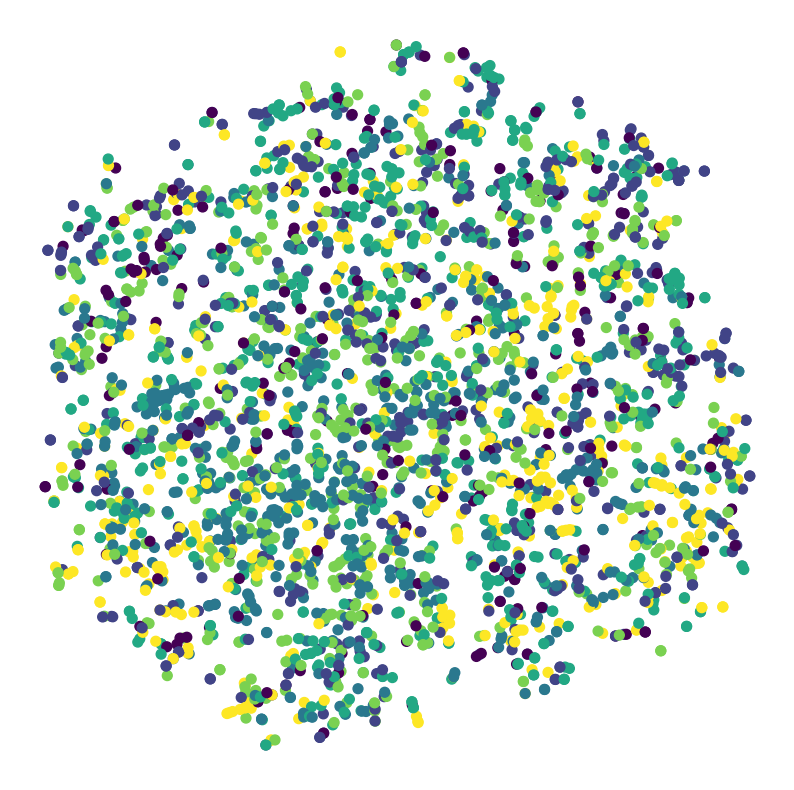

In [ ]:
# Initialize new untrained model
untrained_gat = GAT(dataset.num_features, 8, dataset.num_classes)

# Get embeddings
h, _ = untrained_gat(data.x, data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()

# Visualización de las Incrustaciones

Efectivamente, no hay una estructura aparente. ¿Pero las incrustaciones producidas por nuestro modelo entrenado se ven mejor?

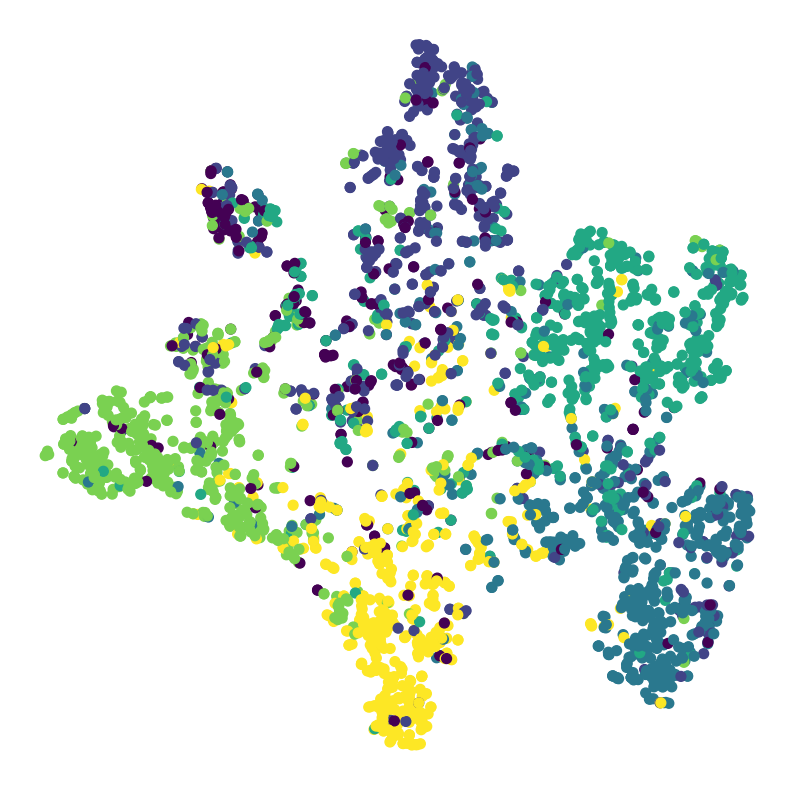

In [ ]:
# Get embeddings
h, _ = gat(data.x, data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()

# Plot accuracy for each node degree

# Resultados de la Visualización

La diferencia es notable: los nodos que pertenecen a las mismas clases se agrupan. Podemos ver seis grupos, correspondientes a las seis clases de trabajos. Hay valores atípicos, pero esto era de esperar: nuestro puntaje de precisión está lejos de ser perfecto.

Anteriormente, especulé que los nodos mal conectados podrían impactar negativamente en el rendimiento en CiteSeer. Así que vamos a verificar eso calculando la precisión del modelo para cada grado.

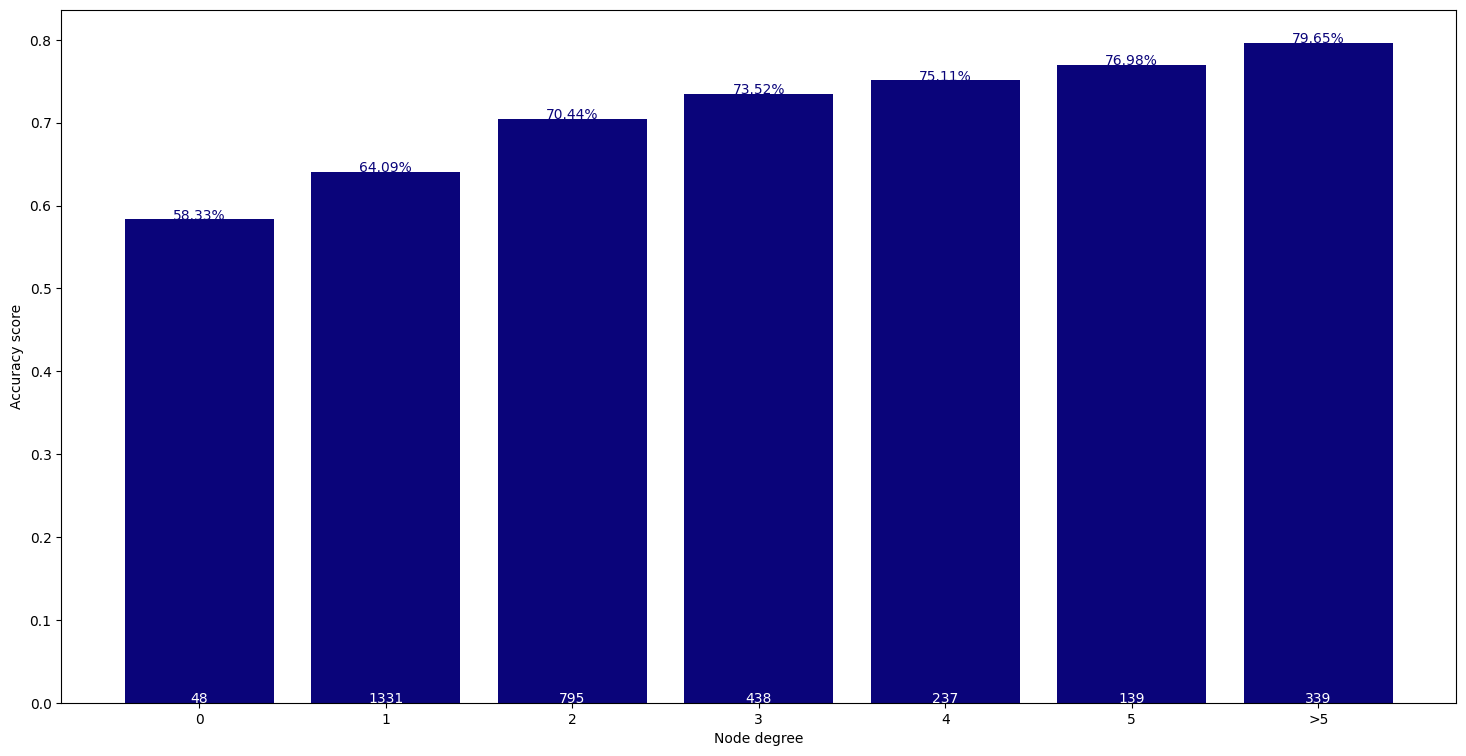

In [ ]:
from torch_geometric.utils import degree

# Get model's classifications
_, out = gat(data.x, data.edge_index)

# Calculate the degree of each node
degrees = degree(data.edge_index[0]).numpy()

# Store accuracy scores and sample sizes
accuracies = []
sizes = []

# Accuracy for degrees between 0 and 5
for i in range(0, 6):
  mask = np.where(degrees == i)[0]
  accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
  sizes.append(len(mask))

# Accuracy for degrees > 5
mask = np.where(degrees > 5)[0]
accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
sizes.append(len(mask))

# Bar plot
fig, ax = plt.subplots(figsize=(18, 9))
ax.set_xlabel('Node degree')
ax.set_ylabel('Accuracy score')
plt.bar(['0','1','2','3','4','5','>5'],
        accuracies,
        color='#0A047A')
for i in range(0, 7):
    plt.text(i, accuracies[i], f'{accuracies[i]*100:.2f}%',
             ha='center', color='#0A047A')
for i in range(0, 7):
    plt.text(i, accuracies[i]//2, sizes[i],
             ha='center', color='white')

# Análisis de los Resultados

Estos resultados confirman nuestra intuición: los nodos con pocos vecinos son efectivamente más difíciles de clasificar. Esto se debe a la naturaleza de las GNN: cuantas más conexiones relevantes tengas, más información puedes agregar.

# Conclusión

Aunque tardan más en entrenarse, las GATs a menudo proporcionan una mejora sustancial sobre las GCNs en términos de precisión. El mecanismo de auto-atención calcula automáticamente los pesos en lugar de coeficientes estáticos para producir mejores incrustaciones. En este artículo,

- Aprendimos cómo calcular pesos dinámicos usando auto-atención
- Implementamos y comparamos dos arquitecturas (una GCN y una GAT) en PyTorch Geometric
- Visualizamos lo que la GAT aprendió con un gráfico t-SNE y el puntaje de precisión para cada grado

Las GATs son una arquitectura estándar en muchas aplicaciones de GNN. Sin embargo, su lento tiempo de entrenamiento puede convertirse en un problema cuando se aplica a conjuntos de datos de gráficos masivos. La escalabilidad es un factor importante en el aprendizaje profundo: más datos a menudo pueden llevar a un mejor rendimiento.